## 네이버 영화리뷰 감성분석 도전하기
\$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt  
\$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt  
\$ mv ratings_*.txt ~/aiffel/sentiment_classification  

$ python3
```
>>> from konlpy.tag import Komoran
>>> komoran = Komoran() 
```
에서 계속 오류가 났지만,  

https://zereight.tistory.com/650  
덕분에 Komoran을 돌릴 수 있다.

https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

https://wikidocs.net/44249
도움받음

왜 단어수를 늘렸는데 정확도가 떨어질까? -> 이해함  
그렇다면 문장의 모든 단어가 빈도수가 낮아서 <UNK>으로 변경된 data는 제거하는 게 더 좋겠습니다. 어떻게 제거하면 좋을까?  
    
    https://wikidocs.net/50739 WORD2VEC도움 URL  
    https://wikidocs.net/21668 진표퍼실님이 알려준 URL

1) 데이터 준비와 확인

2) 데이터로더 구성

3) 모델구성을 위한 데이터 분석 및 가공

    데이터셋 내 문장 길이 분포
    적절한 최대 문장 길이 지정
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

4) 모델구성 및 validation set 구성

   모델은 3가지 이상 다양하게 구성하여 실험해 보세요.
   
5) 모델 훈련 개시

6) Loss, Accuracy 그래프 시각화

7) 학습된 Embedding 레이어 분석 - 유사도 단어
    
8) 한국어 Word2Vec 임베딩 활용하여 성능개선

   한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.
   https://github.com/Kyubyong/wordvectors

평가문항	
 상세기준

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
	3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
	gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함


In [1]:
# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}
type(index_to_word)
for index,word in index_to_word.items():
    print(index,word)
    if index == 20:
        break     이거 돌리면 이해실수도

SyntaxError: invalid syntax (<ipython-input-1-4dac926ffda0>, line 7)

## (E4)Sentimental_Analysis_of_Movie_Dataset_from_NAVER_InYu
### 1) 데이터 준비와 확인 & 2) 데이터로더 구성&

In [6]:
# 필요한 모듈 import 와 read data
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# read data
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

# data 개수
print('훈련용 data 개수 :', len(train_data))
print('테스트용 data 개수 :', len(test_data))

훈련용 data 개수 : 150000
테스트용 data 개수 : 50000


In [7]:
# 데이터 확인해보기
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


부정 감상평 label은 0  
긍정 감상평 lable은 1

### \+ data 전처리 시작

In [8]:
# 비중복 data 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

label은 0, 1뿐이라서 당연히 2개지만 150000개에서 약 4000개 정도의 중복 리뷰가 있다는 것이다.  
중복된 리뷰를 삭제한다.

In [9]:
# 중복 리뷰 삭제
train_data.drop_duplicates(subset=['document'], inplace=True)

train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 가시적으로 확인

   label  count
0      0  73342
1      1  72841


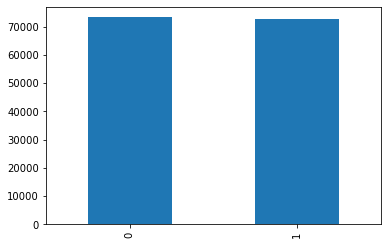

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

부정 감상평이 살짝 많지만 근사한 data 개수를 가진 것을 확일할 수 있었다.  
감상평 중에 Null 값을 가진 샘플이 있는지  확인

In [11]:
print(train_data.isnull().values.any()) # True는 Null 값을 가진 샘플 존재한다는 뜻
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()] # 목록에서 위치 확인

True
id          0
document    1
label       0
dtype: int64


,id,document,label
25857,2172111,NaN,1


In [12]:
# Null 샘플  제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # False가 나와야 Null 샘플이 없다.
print(len(train_data)) # Null 값을 제외한 학습 data

False
146182


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [14]:
# 다시 Null값 확인하고 Null 제거
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
print('전처리 후 학습용 샘플의 개수 :',len(train_data))

전처리 후 학습용 샘플의 개수 : 145791


In [15]:
# 나머지 test data도 동일하게 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


In [31]:
# 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

AttributeError: 'java.lang.String' object has no attribute 'rsplit'

Okt는 열심히 다운받았던 KoNLPy에서 제공하는 형태소 분석기이다. 한국어 토큰화는 띄어쓰기 기준이 아닌 형태소 분석기를 사용한다.  
토큰화 하면서 불용어를 제거하여 x_train에 저장

In [ ]:
tokenizer = Mecab()
x_train = []
for sentence in train_data['document']:
    temp_x = tokenizer.morphs(sentence) # 토큰화
    temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
    x_train.append(temp_x)
    
x_test = []
for sentence in test_data['document']:
    temp_x = tokenizer.morphs(sentence) # 토큰화
    temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
    x_test.append(temp_x)

x_train에서 빈도가 높은 순으로 정수를 부여받는다. 그래서 이중에서 가장 빈도 수가 많은 9996개의 단어로 리스트를만들어서 정수로 인코딩해준다.  
앞에는 \<BOS>, \<PAD>, \<UNK>, \<UNUSED>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 

### 3) 모델구성을 위한 데이터 분석 및 가공
문장 길이를 평준화해서 벡터의 길이는 조정한다.  
Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 하기 때문이다.  
긴 문장은 자르고 짧은 단어는 \<PAD>를 패딩해서 길이를 맞춰준다.

In [ ]:
# 정수로 인코딩 
words = np.concatenate(x_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4) # 변경가능
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

data에 있는 단어 중 9996개에 들지 못한 단어는 <UNK>으로 변경하고 words에 포함된 단어라면 인코딩을 진행합니다.

In [ ]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

x_train = list(map(wordlist_to_indexlist, x_train))
x_test = list(map(wordlist_to_indexlist, x_test))

# y는 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
# return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

# x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print(y_train[:5])

문장 길이를 평준화해서 벡터의 길이는 조정한다.  
Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 하기 때문이다.  
긴 문장은 자르고 짧은 단어는 \<PAD>를 패딩해서 길이를 맞춰준다.

In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 전체 문장 95% 정도를 포함할 수 있게
max_tokens = np.mean(num_tokens) + round(2.5 * np.std(num_tokens)) 
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

RNN은 입력데이터가 순차적으로 처리되기 때문에 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

In [ ]:
# 위의 maxlen 값에 맞춰서 패딩
# post는 data 뒤에 패딩, pre는 data 앞에 패딩
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

### 4) 모델구성 및 validation set 구성

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNN(LSTM)
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# 1-D CNN
model_CNN = keras.Sequential() # 동일
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu')) # 동일
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 


# GlobalMP

model_GlobalMP = keras.Sequential()
model_GlobalMP.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GlobalMP.add(keras.layers.GlobalMaxPooling1D())
model_GlobalMP.add(keras.layers.Dense(8, activation='relu'))
model_GlobalMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()
model_CNN.summary()
model_GlobalMP.summary()


### 5) 모델 훈련 개시 - 1. RNN(LSTM)

In [ ]:
# model 학습 시작 "compile"
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_model_RNN = model_RNN.fit(x_train,
                    y_train,
                    epochs=10,
                    callbacks=[es, mc],
                    batch_size=100,
                    validation_split=0.2)
# test 는 "evaluate"
results_RNN = model_RNN.evaluate(x_test,  y_test, verbose=2)

print(results_RNN)

### 5) 모델 훈련 개시 - 2. 1-D CNN

In [ ]:
# model 학습 시작 "compile"
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_model_CNN = model_CNN.fit(x_train,
                    y_train,
                    epochs=10,
                    callbacks=[es, mc],
                    batch_size=100,
                    validation_split=0.2)
# test 는 "evaluate"
results_CNN = model_CNN.evaluate(x_test,  y_test, verbose=2)

print(results_CNN)

### 5) 모델 훈련 개시 - 3. GlobalMP

In [ ]:
# model 학습 시작 "compile"
model_GlobalMP.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_model_GlobalMP = model_GlobalMP.fit(x_train,
                    y_train,
                    epochs=10,
                    callbacks=[es, mc],
                    batch_size=100,
                    validation_split=0.2)

# test 는 "evaluate"
results_GlobalMP = model_GlobalMP.evaluate(x_test,  y_test, verbose=2)

print(results_GlobalMP)

### 6) Loss, Accuracy 그래프 시각화
3개의 모델에 대한 history 가져오기

In [ ]:
#history_model_RNN
#history_model_CNN
#history_model_GlobalMP
history_dict_RNN = history_model_RNN.history
history_dict_CNN = history_model_CNN.history
history_dict_GlobalMP = history_model_GlobalMP.history
print(history_dict_GlobalMP.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

In [ ]:
import matplotlib.pyplot as plt
# RNN
acc = history_dict_RNN['accuracy']
val_acc = history_dict_RNN['val_accuracy']
loss = history_dict_RNN['loss']
val_loss = history_dict_RNN['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# CNN
acc = history_dict_CNN['accuracy']
val_acc = history_dict_CNN['val_accuracy']
loss = history_dict_CNN['loss']
val_loss = history_dict_CNN['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# GlobalMP
acc = history_dict_GlobalMP['accuracy']
val_acc = history_dict_GlobalMP['val_accuracy']
loss = history_dict_GlobalMP['loss']
val_loss = history_dict_GlobalMP['val_loss']

epochs = range(1, len(acc) + 1)

#fig, ax = plt.subplots(1, 2, sharex=True) 
# fig란 figure로써 - 전체 subplot을 말한다. 
# ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나.전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 
# ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('GlobalMP Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('GlobalMP Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석
- 유사도 단어

In [ ]:
#history_model_RNN
#history_model_CNN
#history_model_GlobalMP
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

### 1. RNN으로 학습된 임베딩 파라미터를 word2vec_RNN.txt에 저장

In [ ]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_RNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_RNN.txt'
f = open(word2vec_file_path_RNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_RNN = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_RNN[i, :])))))
f.close()

### 2. CNN으로 학습된 임베딩 파라미터를 word2vec_CNN.txt에 저장

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_CNN = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_CNN.txt'
f = open(word2vec_file_path_CNN, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_CNN = model_CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_CNN[i, :])))))
f.close()

### 3. GlobalMP로 학습된 임베딩 파라미터를 word2vec_GlobalMP.txt에 저장

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_GlobalMP = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_GlobalMP.txt'
f = open(word2vec_file_path_GlobalMP, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_GlobalMP = model_GlobalMP.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_GlobalMP[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors01 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_RNN, binary=False)
word_vectors02 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_CNN, binary=False)
word_vectors03 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_GlobalMP, binary=False)
vector_RNN = word_vectors01['한국']
#vector_CNN = word_vectors['한국']
#vector_GlobalMP = word_vectors['한국']
vector_RNN

In [ ]:
#RNN학습된 임베딩
word_vectors01.similar_by_word("여름")

In [ ]:
#CNN학습된 임베딩
word_vectors02.similar_by_word("여름")

In [ ]:
#GlobalMP학습된 임베딩
word_vectors03.similar_by_word("여름")

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [ ]:
import gensim
from gensim.models import KeyedVectors
word2vec_file_path_ko = os.getenv('HOME')+'/aiffel/ko.bin'
word_vectors_ko = gensim.models.Word2Vec.load(word2vec_file_path_ko)

In [ ]:
word_vectors_ko.similar_by_word("여름")

## 훈련된 임베딩 모델에 적용하기

In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors_ko:
        embedding_matrix[i] = word_vectors_ko[index_to_word[i]]

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# RNN
model_RNN = keras.Sequential()
model_RNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model_RNN.add(keras.layers.Dense(8, activation='relu'))
model_RNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# 1-D CNN
model_CNN = keras.Sequential() # 동일
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.GlobalMaxPooling1D())
model_CNN.add(keras.layers.Dense(8, activation='relu')) # 동일
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. 


# GlobalMP

model_GlobalMP = keras.Sequential()
model_GlobalMP.add(keras.layers.GlobalMaxPooling1D())
model_GlobalMP.add(keras.layers.Dense(8, activation='relu'))
model_GlobalMP.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()
model_CNN.summary()
model_GlobalMP.summary()


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### model-2. 1-D CNN

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential() # 동일
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # 동일
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu')) # 동일
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. # 동일

model.summary()

In [ ]:
# model 학습 시작 "compile"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

### model-3. GlobalMaxPooling1D() 레이어 하나만

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
model.layers[0]

In [ ]:
# model 학습 시작 "compile"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

## 7) 학습된 Embedding 레이어 분석
### Word2Vec 만들기
### gensim
워드벡터를 다루는데 유용함

네이버 리뷰나 IMDB 리뷰는 문장들에서 긍정과 부정을 나타내는걸 알아내는 모델을 학습하는거였고 word2vec는 각 단어마다 가지고 잇는 고유벡터값 특성 표현 식?을 찾아내는데 의미가 있는거라고 하네요

In [ ]:
import gensim
from gensim.models import KeyedVectors
word2vec_file_path_ko = os.getenv('HOME')+'/aiffel/ko.bin'
word_vectors_ko = gensim.models.Word2Vec.load(word2vec_file_path_ko)
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

In [ ]:
# Word2Vec 훈련시키기
import gensim
model = gensim.models.Word2Vec.load('/home/aiffel/aiffel/ko.bin')

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

In [ ]:
result = model.wv.most_similar("사랑")
print(result)

In [ ]:
vocab_size = 30185    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 ?????? 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    verbose = 1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
train_data = pd.read_table('/home/aiffel/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/home/aiffel/aiffel/sentiment_classification/ratings_test.txt')
print(len(train_data))
print(len(test_data))
train_data[:5]

In [ ]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))

In [ ]:
# 비중복 data 개수
train_data['document'].nunique(), train_data['label'].nunique()

In [ ]:
# 중복 리뷰 삭제
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
# 다시 Null값 확인하고 Null 제거
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
print('전처리 후 학습용 샘플의 개수 :',len(train_data))

In [ ]:
# 나머지 test data도 동일하게 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [3]:
# 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

tokenizer = Mecab()
x_train = []
for sentence in train_data['document']:
    temp_x = tokenizer.morphs(sentence) # 토큰화
    temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
    x_train.append(temp_x)
    
x_test = []
for sentence in test_data['document']:
    temp_x = tokenizer.morphs(sentence) # 토큰화
    temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
    x_test.append(temp_x)

NameError: name 'Okt' is not defined

In [ ]:
# 정수 인코딩 
words = np.concatenate(x_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4) # 변경가능
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

x_train = list(map(wordlist_to_indexlist, x_train))
x_test = list(map(wordlist_to_indexlist, x_test))

# y는 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 전체 문장 95% 정도를 포함할 수 있게
max_tokens = np.mean(num_tokens) + round(2.5 * np.std(num_tokens)) 
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

In [ ]:
# 위의 maxlen 값에 맞춰서 패딩
# post는 data 뒤에 패딩, pre는 data 앞에 패딩
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    verbose = 1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [ ]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['computer']
# print(len(vector))
# vector     # 무려 300dim의 워드 벡터입니다.

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다. 이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    verbose = 1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

### model-4. LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 8  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

### plt

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해지게 마련입니다.

## 7) 학습된 Embedding 레이어 분석
### Word2Vec

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [ ]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
print(len(vector))
vector     # 무려 300dim의 워드 벡터입니다.

In [ ]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다. 이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것입니다.

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
prtl_x_train = x_train[10000:]
prtl_y_train = y_train[10000:]

epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(prtl_x_train,
                    prtl_y_train,
                    epochs=epochs,
                    batch_size=512,
                    verbose=1)

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


              
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)

2) 데이터로더 구성

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

    데이터의 중복 제거
    NaN 결측치 제거
    한국어 토크나이저로 토큰화
    불용어(Stopwords) 제거
    사전word_to_index 구성
    텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train, y_train, X_test, y_test, word_to_index 리턴

In [ ]:
# 시간오래걸린다
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 어떤 비율로 train과 test를 나눴는지 모르겠음
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
#     index_to_word = {index:word for word, index in word_to_index.items()}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [ ]:
print(x_train[3]) # 왜 BOS로 시작 안하지?

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[:])

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


print(x_train[3])
print(get_decoded_sentence(x_train[3], index_to_word))
print('라벨: ', y_train[3])  # 6번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

# x_train에 아직 BOS 안 들어감

In [ ]:
print(index_to_word[8410])
print(index_to_word[158]) 

In [ ]:
print(len(x_train))
print(len(x_test))
print(len(word_to_index))

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('아이언맨 영화 좋다', word_to_index))

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

encoded_sentences = get_encoded_sentences('개노잼', word_to_index) # 이해안감
print(encoded_sentences)


In [ ]:
# 지금 보니까 보정 안하는 게 맞음
# # 보정 -> 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
# word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# # 처음 몇 개 인덱스는 사전에 정의되어 있습니다
# word_to_index["<PAD>"] = 0
# word_to_index["<BOS>"] = 1
# word_to_index["<UNK>"] = 2  # unknown
# word_to_index["<UNUSED>"] = 3

# index_to_word[0] = "<PAD>"
# index_to_word[1] = "<BOS>"
# index_to_word[2] = "<UNK>"
# index_to_word[3] = "<UNUSED>"

# index_to_word = {index:word for word, index in word_to_index.items()}

# print(x_train[3])
# print(get_decoded_sentence(x_train[3], index_to_word))
# print('라벨: ', y_train[3])  # 6번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

In [ ]:
print(index_to_word[0]) 
print(index_to_word[1]) 
print(index_to_word[2]) 
print(index_to_word[3])  # padding 확인

In [ ]:
nn = 3
print(x_train[nn])
print(get_decoded_sentence(x_train[nn], index_to_word))
print('라벨: ', y_train[nn])  # (nn+1)번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

In [ ]:
nn = 500
print(x_train[nn])
print(get_decoded_sentence(x_train[nn], index_to_word))
print('라벨: ', y_train[nn])  # (nn+1)번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

encoding 숫자 출력할 때 왜 1이 안나올까?

In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # for RNN
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                     padding='pre', # for RNN
                                                      maxlen=maxlen)

print('(x_train data 개수, 각 data의 length) =', x_train.shape)

In [ ]:
# index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
nn = 3
print(x_train[nn])
print(get_decoded_sentence(x_train[nn], index_to_word))
print('라벨: ', y_train[nn])  # (nn+1)번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

### RNN

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - RNN
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # 동일 # model의 첫번째 레이어
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu')) # 동일
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. # 동일

model.summary()

In [ ]:
# validation set 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

In [ ]:
# model 학습 시작 "complie"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# fit에 주목
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1000,
                    verbose=1)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

### 1-D CNN

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential() # 동일
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # 동일
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu')) # 동일
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다. # 동일

model.summary()

In [ ]:
# model 학습 시작 "complie"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# fit에 주목
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1500,
                    verbose=1)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

In [ ]:
# post로 pad 하고 진행해보기
# 시간오래걸린다
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 어떤 비율로 train과 test를 나눴는지 모르겠음
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
#     index_to_word = {index:word for word, index in word_to_index.items()}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                     padding='post',
                                                      maxlen=maxlen)

In [ ]:
nn = 3
print(x_train[nn])
print(get_decoded_sentence(x_train[nn], index_to_word))
print('라벨: ', y_train[nn])  # (nn+1)번째 리뷰데이터의 라벨 부정은 0, 긍정은 1

In [ ]:
# model 학습 시작 "complie"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# fit에 주목
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1500,
                    verbose=1)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

### GlobalMaxPooling1D() 레이어 하나만

In [ ]:
### GlobalMaxPooling1D() 레이어 하나만

# post로 pad 하고 진행해보기
# 시간오래걸린다
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 어떤 비율로 train과 test를 나눴는지 모르겠음
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
#     index_to_word = {index:word for word, index in word_to_index.items()}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)


In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

In [ ]:
# post
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                     padding='post',
                                                      maxlen=maxlen)

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
# model 학습 시작 "complie"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# fit에 주목
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1500,
                    verbose=1)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

### 제일 높게 나온 Global pre로 진행해보기

In [ ]:
# pre로 pad 하고 진행해보기
# 시간오래걸린다
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 어떤 비율로 train과 test를 나눴는지 모르겠음
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
#     index_to_word = {index:word for word, index in word_to_index.items()}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)


In [ ]:
total_data_text = list(x_train) + list(x_test)
# 텍스트 데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

In [ ]:
# pre
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                      value=word_to_index["<PAD>"],
                                                     padding='pre',
                                                      maxlen=maxlen)

In [ ]:
# model 학습 시작 "complie"
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# fit에 주목
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1500,
                    verbose=1)

In [ ]:
# test 는 "evaluate"
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)